# A Tutorial on Spectral Clustering


Autor: Breno Serrano de Araujo  
Data: 10/12/2018


**Objetivo**:

Este notebook consiste em implementar dos algoritmos do paper "A Tutorial on Spectral Clustering" de Ulrike von Luxburg (https://arxiv.org/abs/0711.0189/), e compará-los.

Primeiramente vou importar as bibliotecas necessárias.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import cycle, islice

import networkx as nx
from scipy import sparse
from sklearn.cluster import KMeans

np.random.seed(0)

### Spectral Clustering

Foram implementados 3 algoritmos para Spectral Clustering, como descrito no artigo:
- Unnormalized Spectral Clustering 
- Normalized Spectral Clustering according to Shi and Malik (2000) - Usa a matriz Laplaciana baseada em Random Walk ($L_{rw}$)
- Normalized Spectral Clustering according to Ng, Jordan and Weiss (2002) - Usa a matriz Laplaciana simétrica ($L_{sym}$)

O código se encontra abaixo. Foi feita uma função para cada um dos algoritmos. Cada função recebe como entrada o dataset $X$ (que já deve estar devidamente normalizado), o número de clusters $k$ e o argumento $params$ que deve conter informações que definem como será gerado o grafo de similaridade utilizado pelo algoritmo. Mais detalhes e comentários acompanham o código.

In [2]:
def getClusterCentroids(X,spectral_labels):
    """
    Funcao auxiliar para obter os centroids dos clusters a partir dos dados X e das marcacoes de spectral_labels
    """
    tmp = pd.DataFrame(X)
    cols = tmp.columns
    tmp['spectral_labels'] = spectral_labels
    return tmp.groupby("spectral_labels")[cols].mean().values


def unnormalizedSpectralClustering(X,k,params):
    """
    Unnormalized Spectral Clustering
    
    Inputs: 
    X - Array of data points
    k - Number of clusters to construct
    params - Additional parameters for constructing the similarity graph
    """ 
    n = len(X)

    ## Construct a similarity graph by one of the ways described in Section 2. Let W be its weighted adjacency matrix
    # Computes the (weighted) graph of k-Neighbors for points in X. The default distance is 'euclidean'
    A = kneighbors_graph(X, params['k_neighbors'], mode='distance', metric='euclidean', include_self=True)
    
    ## Compute the unnormalized Laplacian L
    G = nx.from_scipy_sparse_matrix(A)
    L = nx.laplacian_matrix(G)
    
    ## Compute the first k eigenvectors u_1,...,u_k of L
    eigenvalues, eigenvectors = sparse.linalg.eigs(L, k=k, which='SM')
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:k]
    
    ## Let U be the matrix containing the vectors u_1,...,u_k as columns
    ## For i=1,...,n, let y_i be the vector corresponding to the i-th row of U
    Y = eigenvectors[:,kfirst_indices]
    
    ## Cluster the points (y_i)i=1,...,n with the k-means algorithm into clusters C_1,...,C_k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y)
    
    ## Output: Clusters A_1,...,A_k with A_i = {j|y_j in C_i}
    return {
        'labels': kmeans.labels_,
        'centroids': getClusterCentroids(X,kmeans.labels_)
    }

def normalizedRWSpectralClustering(X,k,params):
    """
    Normalized Spectral Clustering according to Shi and Malik (2000)
    Uses the normalized Random Walk Laplacian matrix
    
    Inputs: 
    X - Array of data points
    k - Number of clusters to construct
    params - Additional parameters for constructing the similarity graph
    """ 
    
    ## Construct a similarity graph by one of the ways described in Section 2. Let W be its weighted adjacency matrix
    # Computes the (weighted) graph of k-Neighbors for points in X. The default distance is 'euclidean'
    A = kneighbors_graph(X, params['k_neighbors'], mode='distance', metric='euclidean', include_self=True)

    ## Compute the unnormalized Laplacian L
    G = nx.from_scipy_sparse_matrix(A)
    L = nx.laplacian_matrix(G)
    
    degreeView = G.degree(G.nodes(), weight='weight')
    degrees = np.array(degreeView)[:,1]
    D = sparse.diags(degrees)
    
    ## Compute the first k generalized eigenvectors u_1,...,u_k of the generalized eigenproblem Lu=lambda*Du
    eigenvalues, eigenvectors = sparse.linalg.eigs(L, k=k, M=D, which='SM') # SM = Smallest Magnitude
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:k]
    
    ## Let U be the matrix containing the vectors u_1,...,u_k as columns
    U = eigenvectors[:,kfirst_indices]

    ## For i=1,...,n, let y_i be the vector corresponding to the i-th row of U
    Y = U

    ## Cluster the points (y_i)i=1,...,n with the k-means algorithm into clusters C_1,...,C_k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y)

    ## Output: Clusters A_1,...,A_k with A_i = {j|y_j in C_i}    
    return {
        'labels': kmeans.labels_,
        'centroids': getClusterCentroids(X,kmeans.labels_)
    }


def normalizedSymSpectralClustering(X,k,params):
    """
    Normalized Spectral Clustering according to Ng, Jordan and Weiss (2002)
    Uses the normalized symmetric Laplacian matrix
    
    Inputs: 
    X - Array of data points
    k - Number of clusters to construct
    params - Additional parameters for constructing the similarity graph
    """ 
    n = len(X)
    
    ## Construct a similarity graph by one of the ways described in Section 2. Let W be its weighted adjacency matrix
    # Computes the (weighted) graph of k-Neighbors for points in X. The default distance is 'euclidean'
    A = kneighbors_graph(X, params['k_neighbors'], mode='distance', metric='euclidean', include_self=True)
    
    ## Compute the normalized Laplacian L_sym
    G = nx.from_scipy_sparse_matrix(A)
    L_sym = nx.normalized_laplacian_matrix(G)
    
    ## Compute the first k eigenvectors u_1,...,u_k of L_sym
    eigenvalues, eigenvectors = sparse.linalg.eigs(L_sym, k=k, which='SM')
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:k]
    
    ## Let U be the matrix containing the vectors u_1,...,u_k as columns
    U = eigenvectors[:,kfirst_indices]
    
    ## Form the matrix T from U by normalizing the rows to norm 1
    T = U / np.sqrt(np.sum(U**2, axis=1))[:,np.newaxis]
    
    ## For i=1,...,n, let y_i be the vector corresponding to the i-th row of T
    ## Cluster the points (y_i)i=1,...,n with the k-means algorithm into clusters C_1,...,C_k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(T)
    
    ## Output: Clusters A_1,...,A_k with A_i = {j|y_j in C_i} 
    return {
        'labels': kmeans.labels_,
        'centroids': getClusterCentroids(X,kmeans.labels_)
    }

### Testes preliminares

Como um primeiro teste, vou utilizar o Spectral Clustering em 6 datasets bem simples e compará-lo com o método mais conhecido KMeans.  
A análise a seguir foi inspirada na seguinte página do sklearn:  
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py  

Primeiramente vou gerar os datasets, a seguir.

In [3]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


In [4]:
simple_datasets = [
    (noisy_circles, {'name': 'Noisy Circles','n_clusters': 2}),
    (noisy_moons, {'name': 'Noisy Moons', 'n_clusters': 2}),
    (varied, {'name': 'Blobs with varied variances','n_clusters': 3}),
    (aniso, {'name': 'Anisotropic data', 'n_clusters': 3}),
    (blobs, {'name': 'Blobs', 'n_clusters': 3}),
    (no_structure, {'name': 'No structure', 'n_clusters': 3})]

A figura abaixo mostra os 6 datasets que serão utilizados nesta análise preliminar, para que o leitor possa visualizar as características de cada uma das distribuições.

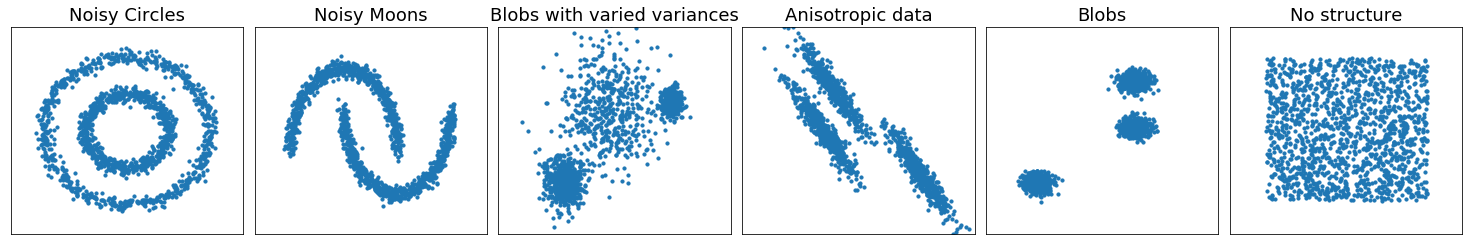

In [5]:
plt.figure(figsize=(9 * 2 + 3, 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1
for i_dataset, (dataset, dataset_params) in enumerate(simple_datasets):
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    name = dataset_params['name']
    plt.subplot(1, len(simple_datasets), plot_num)
    plt.title(name, size=18)
    plt.scatter(X[:, 0], X[:, 1], s=10) #c=y)#, cmap='Set1')

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
    plot_num += 1

Agora vamos de fato rodar os algoritmos de clusterização em cada um dos datasets apresentados acima e visualizar os resultados obtidos, em comparação com o KMeans.  
A partir do resultado abaixo, nota-se que os algoritmos de Spectral Clustering em geral conseguem um resultado melhor do que o KMeans, especialmente no dataset "Noisy Circles", onde os dados não são linearmente separáveis. Contudo, o algoritmo parece não ter exatamente o resultado desejado para alguns casos, como por exemplo para o Normalized Spectral Clustering usando matrix Laplaciana simétrica, aplicado aos datasets "Blobs with varied variances" e "Anisotropic data". Estes algoritmos possuem muitos parâmetros e o ajuste deles nem sempre é uma tarefa trivial, como é indicado no artigo. O resultado final é bastante sensível ao ajuste adequado desses parâmetros. Para os resultados abaixo foi usado o grafo de similaridade k-nearest neighbors com um valor de k=12.

C:\Users\Breno\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


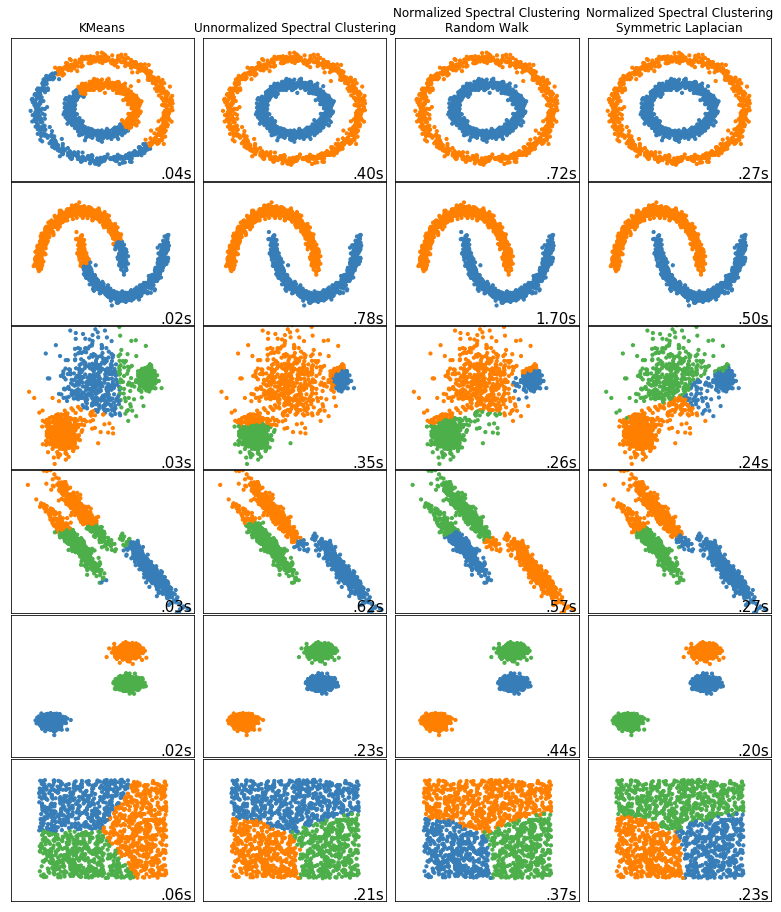

In [6]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(4 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, params) in enumerate(simple_datasets):
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    
    clustering_algorithms = (
        ('KMeans', kmeans),
        ('Unnormalized Spectral Clustering', unnormalizedSpectralClustering),
        ('Normalized Spectral Clustering\nRandom Walk', normalizedRWSpectralClustering),
        ('Normalized Spectral Clustering\nSymmetric Laplacian', normalizedSymSpectralClustering)
    )
    
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        if name == 'KMeans':
            algorithm.fit(X)
        else:
            k = params['n_clusters']
            spectral_params = {
                'k_neighbors': 12
            }
            result = algorithm(X,k,spectral_params)
            
        t1 = time.time()
        
        if name == 'KMeans':
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = result['labels']
        
        plt.subplot(len(simple_datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Análise Experimental

Na análise a seguir os 3 algoritmos de Spectral Clustering serão testados no dataset de Image Segmentation da UCI (disponível em http://archive.ics.uci.edu/ml/datasets/image+segmentation/).  
  
O dataset contém features criadas a partir dos valores R,G,B de segmentos de imagens ao ar livre. As features são valores númericos, como por exemplo saturação média e intensidade média. Cada segmento é classificado como pertencendo a uma dentre 7 classes. As classes são: BRICKFACE, FOLIAGE, GRASS, CEMENT, PATH, SKY e WINDOW. Para uma descrição mais detalhada sobre os dados, pode-se consultar o link acima.

Segue abaixo uma descrição de cada uma das features, copiado do link:

-----
1. region-centroid-col: the column of the center pixel of the region. 
2. region-centroid-row: the row of the center pixel of the region. 
3. region-pixel-count: the number of pixels in a region = 9. 
4. short-line-density-5: the results of a line extractoin algorithm that counts how many lines of length 5 (any orientation) with low contrast, less than or equal to 5, go through the region. 
5. short-line-density-2: same as short-line-density-5 but counts lines of high contrast, greater than 5. 
6. vedge-mean: measure the contrast of horizontally adjacent pixels in the region. There are 6, the mean and standard deviation are given. This attribute is used as a vertical edge detector. 
7. vegde-sd: (see 6) 
8. hedge-mean: measures the contrast of vertically adjacent pixels. Used for horizontal line detection. 
9. hedge-sd: (see 8). 
10. intensity-mean: the average over the region of (R + G + B)/3 
11. rawred-mean: the average over the region of the R value. 
12. rawblue-mean: the average over the region of the B value. 
13. rawgreen-mean: the average over the region of the G value. 
14. exred-mean: measure the excess red: (2R - (G + B)) 
15. exblue-mean: measure the excess blue: (2B - (G + R)) 
16. exgreen-mean: measure the excess green: (2G - (R + B)) 
17. value-mean: 3-d nonlinear transformation of RGB. (Algorithm can be found in Foley and VanDam, Fundamentals of Interactive Computer Graphics) 
18. saturatoin-mean: (see 17) 
19. hue-mean: (see 17)

  
-----
   
Este dataset é composto por 2 arquivos de dados, segmentation.data e segmentation.test. Usarei para esta análise o arquivo segmentation.test, que contém 2100 linhas (observações). 

Após baixar o arquivo para máquina local, carrego os dados para o Python abaixo. Faço um pré-processamento bem simples para que os valores de cada campo fiquem na mesma escala, usando o StandardScaler. Além disso, aplico o LabelEncoder às classes e crio um vetor y com as classes reais. 

In [7]:
ds = pd.read_csv("./datasets/segmentation.test.txt")

X = ds.values
X = StandardScaler().fit_transform(X)
n = len(X)

y = LabelEncoder().fit_transform(ds.index)

Note que temos 300 observações de cada classe. Ou seja, as classes estão balanceadas.

In [8]:
ds.index.value_counts()

WINDOW       300
FOLIAGE      300
BRICKFACE    300
GRASS        300
CEMENT       300
PATH         300
SKY          300
dtype: int64

Abaixo temos uma visão de todas as features do dataset.

In [9]:
ds.head()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
GRASS,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
GRASS,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
GRASS,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
GRASS,47.0,232.0,9,0.0,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
GRASS,97.0,186.0,9,0.0,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654


In [10]:
n_clusters = len(np.unique(y))
print("Numero de clusters:",str(n_clusters))

Numero de clusters: 7


Para se ter uma ideia como os dados estão distribuídos em cada classe, faço alguns scatter plots mostrando como os dados estão distribuidos para alguns pares de features. Decidi mostrar os 3 últimos campos do dataset (VALUE-MEAN, SATURATION-MEAN e HUE-MEAN). A escolha destes 3 campos foi feita de forma arbitrária.  
  
Dada a quantidade de features, fica difícil visualizar os dados de forma multi-dimensional e resolvi visualizar somente estas 3 feaures. Pode-se notar, desde já, que algumas classes parecem ser facilmente separáveis.

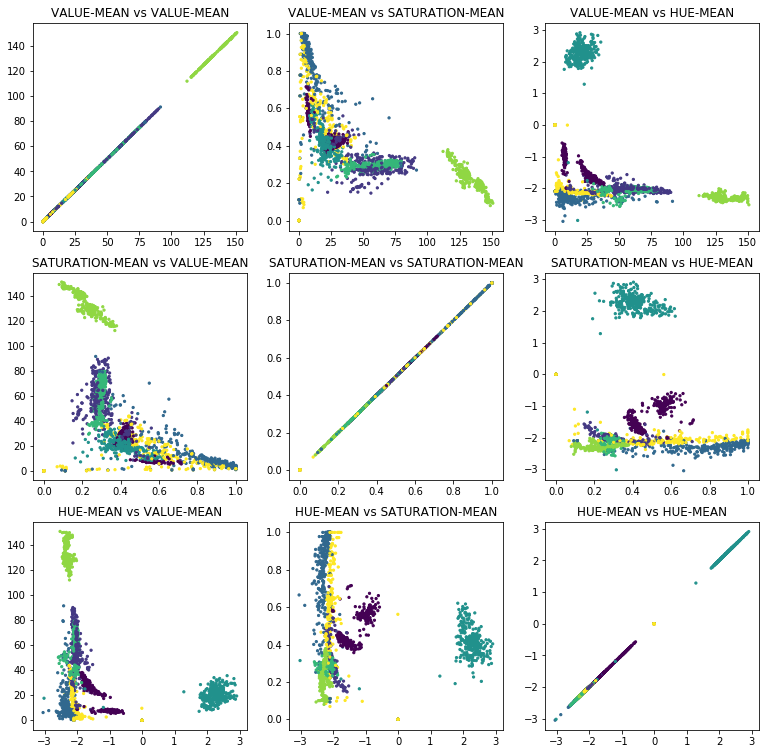

In [11]:
tmp = ds.iloc[:,-3:]
num_cols = tmp.shape[1]

plt.figure(figsize=(13,13))

plot_num = 1
for row in range(num_cols):
    for col in range(num_cols):
        plt.subplot(num_cols, num_cols, plot_num)
        plt.scatter(tmp.iloc[:,row], tmp.iloc[:,col], s=5, c=y)
        plt.title("{} vs {}".format(tmp.columns[row], tmp.columns[col]))
        
        plot_num += 1

Vamos agora rodar o KMeans e os algoritmos de Spectral Clustering e comparar os seus resultados.

Para avaliar o desempenho da clusterização, vamos comparar os resultados com as classes reais do dataset. 
Como temos acesso as classes reais, podemos usar métricas externas de avaliação da clusterização. A página da Wikipedia (link: https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation/) dá uma boa ideia geral sobre a diferença entre métricas internas e externas para avaliação de clusterização.
  
A métrica escolhida para este trabalho foi o V-measure, que é uma métrica externa baseada em entropia, introduzida por Andrew Rosenberg e Julia Hirschberg no artigo "V-Measure: A conditional entropy-based external cluster evaluation
measure" (disponível em: http://www.aclweb.org/anthology/D07-1043 ). O V-measure é a média harmônica entre a as métricas de homogeneidade e completude, que são duas características desejáveis de uma clusterização, segundo Andrew Rosenberg.  
A documentação do scikit-learn se encontra em:  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score/)

Para a análise a seguir foi definido o valor de k=150 para a construção do grafo de k-nearest neighbors.

In [12]:
# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

# Spectral Clustering
params = {
    'k_neighbors': 150
}
# Unnormalized 
unnorm = unnormalizedSpectralClustering(X,n_clusters,params)
y_unnorm = unnorm['labels']
# Normalized - Random Walk Laplacian
norm_rw = normalizedRWSpectralClustering(X,n_clusters,params)
y_rw = norm_rw['labels']
# Normalized - Symmetric Laplacian
norm_sym = normalizedSymSpectralClustering(X,n_clusters,params)
y_sym = norm_sym['labels']

C:\Users\Breno\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Como podemos ver abaixo, para esta escolha de k e utilizando a métrica de V-measure, obtivemos um melhor desempenho na clusterização utilizando a clusterização espectral, em comparação com o KMeans.  
O KMeans resultou em um V-measure de 0.59, enquanto que os algoritmos de clusterização espectral apresentaram V-measures acima de 0.63.

In [13]:
from sklearn.metrics.cluster import normalized_mutual_info_score, v_measure_score
print("KMeans")
print("V-measure: {}".format(v_measure_score(y, y_kmeans).round(4)))
print("-------------------")
print("Spectral Clustering")
print("Unnormalized")
print("V-measure: {}".format(v_measure_score(y, y_unnorm).round(4)))
print()
print("Normalized - Random Walk Laplacian")
print("V-measure: {}".format(v_measure_score(y, y_rw).round(4)))
print()
print("Normalized - Symmetric Laplacian")
print("V-measure: {}".format(v_measure_score(y, y_sym).round(4)))

KMeans
V-measure: 0.5947
-------------------
Spectral Clustering
Unnormalized
V-measure: 0.6397

Normalized - Random Walk Laplacian
V-measure: 0.6333

Normalized - Symmetric Laplacian
V-measure: 0.6338


O artigo discute também o uso de outros grafos de similaridade, como o "fully connected graph" e o "$\epsilon$-neighborhood graph". 
Estes grafos, para serem construídos, fazem uso de matrizes densas e portanto demandam mais espaço em memória para rodarem. Fiz alguns testes com datasets reduzidos implementando estes grafos, porém devido a limitações de memória na minha máquina não foi possível implementar algoritmos que utilizem estes tipos de grafos para rodar em datasets de tamanho considerável, como o de Image Segmentation. Sendo assim, resolvi me ater ao grafo de k-nearest neighbors e fazer uma análise de sensibilidade da clusterização ao valor de k.

# Análise de sensibilidade k-NN

A seguir vamos analisar como o desempenho da clusterização varia para alguns valores de k, usando o grafo de similaridade baseado em k-NN.
Pode-se ver que para valores relativamente baixos de k, os algoritmos de clusterização espectral apresentam um desempenho pior do que o KMeans. A medida que aumentamos o valor de k, a clusterização espectral apresenta uma melhora no desempenho, até que supera o KMeans, quando k é aproximadamente igual a 70. A partir de um certo valor seu desempenho retorna a cair, ficando novamente inferior ao do KMeans, a partir de aproximadamente k=350.
  
Pode-se ver que o desempenho da clusterização é bastante sensível ao valor de k. Como o próprio artigo de Ulrike von Luxburg cita, "a clusterização espectral pode ser bastante sensível a mudanças no grafo de similaridade e à escolha de seus parâmetros". O artigo sugere algumas regras empiricas ("rules of thumb") para a escolha dos parâmetros, porém afirma que elas não são baseadas em fundamentos teóricos sólidos.

C:\Users\Breno\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


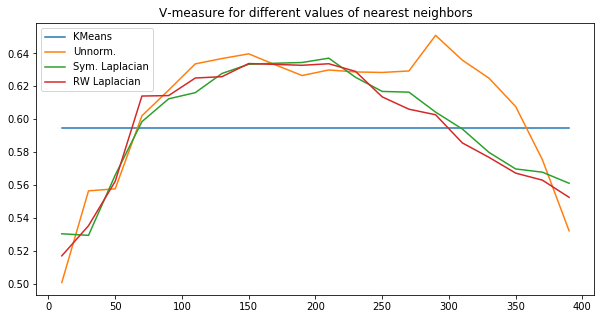

In [14]:
k_neighbor_values = np.arange(10,400,20)

measure_kmeans = []
measure_unnorm = []
measure_rw = []
measure_sym = []

for num_neighbors in k_neighbor_values:
    #print("Number of nearest neighbors k={}".format(num_neighbors))
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    y_kmeans = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Spectral Clustering
    params = {
        'k_neighbors': num_neighbors
    }
    # Unnormalized 
    unnorm = unnormalizedSpectralClustering(X,n_clusters,params)
    y_unnorm = unnorm['labels']
    # Normalized - Random Walk Laplacian
    norm_rw = normalizedRWSpectralClustering(X,n_clusters,params)
    y_rw = norm_rw['labels']
    # Normalized - Symmetric Laplacian
    norm_sym = normalizedSymSpectralClustering(X,n_clusters,params)
    y_sym = norm_sym['labels']
    
    measure_kmeans.append(v_measure_score(y, y_kmeans))
    measure_unnorm.append(v_measure_score(y, y_unnorm))
    measure_rw.append(v_measure_score(y, y_rw))
    measure_sym.append(v_measure_score(y, y_sym))

plt.figure(figsize=(10,5))
plt.title("V-measure for different values of nearest neighbors")
plt.plot(k_neighbor_values, measure_kmeans, label='KMeans')
plt.plot(k_neighbor_values, measure_unnorm, label='Unnorm.')
plt.plot(k_neighbor_values, measure_rw, label='Sym. Laplacian')
plt.plot(k_neighbor_values, measure_sym, label='RW Laplacian')
plt.legend()

# Referências:

Ulrike von Luxburg, A Tutorial on Spectral Clustering  
https://arxiv.org/abs/0711.0189

Scikit-Learn, Comparing different clustering algorithms on toy datasets  
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

UCI, Image Segmentation Data Set  
http://archive.ics.uci.edu/ml/datasets/image+segmentation/

Wikipedia, Cluster Analysis, External Evaluation  
https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation

Andrew Rosenberg, Julia Hirschberg, V-Measure: A conditional entropy-based external cluster evaluation
measure  
http://www.aclweb.org/anthology/D07-1043

Scikit-Learn, v_measure_score documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score/

